In [1]:
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")
import drjit as dr
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse, LOSS_FNS
from utils.plot import (
    plot_loss_linear_interp_1d,
    plot_loss_bilinear_interp_2d,
    plot_losses,
)

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

In [2]:
def reset_scene():
    return mi.load_file(
        os.path.join(
            ROOT_DIR, f"scenes/basic_face.xml"
        )
    )

In [3]:
# generate envmap using 3 colors with continuous transitions
def generate_envmap_tex(res = (256,513,4)):
    envmap = np.zeros(res)
    n1 = res[1] //4
    n2 = n1
    n3 = n1
    n4 = res[1] - 3*n1
    envmap[:, :, 0] = np.hstack([np.linspace(1, 1, n1), np.linspace(1, 0, n2), np.linspace(0, 1, n3), np.linspace(1, 1, n4)])
    envmap[:, :, 1] = np.hstack([np.linspace(0.2, 0.2, n1), np.linspace(0.2, 0.1, n2), np.linspace(0.1, 0.0, n3), np.linspace(0.0, 0.0, n4)])
    envmap[:, :, 2] = np.hstack([np.linspace(0, 0, n1), np.linspace(0, 1, n2), np.linspace(1, 0, n3), np.linspace(0, 0, n4)])
    envmap[:, :, 3] = 1
    return mi.TensorXf(envmap)

In [4]:
mi.Bitmap(generate_envmap_tex())

Bitmap[
  pixel_format = rgba,
  component_format = float32,
  size = [513, 256],
  srgb_gamma = 0,
  struct = Struct<16>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
    float32 A; // @12, alpha
  ],
  data = [ 2 MiB of image data ]
]

In [63]:
def init_scene_params(theta=0.0):
    scene = reset_scene()
    params = mi.traverse(scene)
    params["emitter.data"] = generate_envmap_tex()
    params['PerspectiveCamera.to_world'] = mi.Transform4f.rotate(axis=[0,1,0], angle=theta) @ params['PerspectiveCamera.to_world']
    params.update()
    return scene, params

# Reference scene rendering - theta = -89

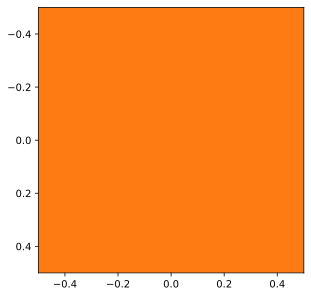

In [37]:
scene_ref, param_ref = init_scene_params(-89.0)

# Render reference images
img_ref = mi.render(scene_ref, seed=0, spp=1)
img_ref_bm = image_to_bm(img_ref)

# Plot
plt.imshow(img_ref_bm)

## sample with theta = 0.0

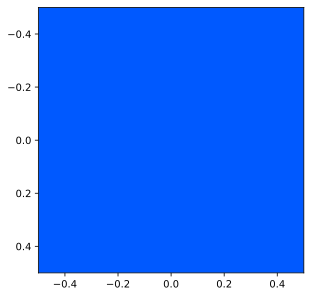

In [36]:
scene, params = init_scene_params(0.0)

params.update()

# Render images
image = mi.render(scene, seed=0, spp=1)
image_bm = image_to_bm(image)

# Plot
plt.imshow(image_bm)

## sample with theta = 89.0

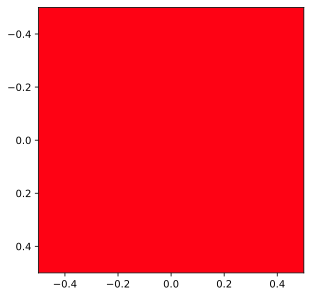

In [60]:
scene, params = init_scene_params(89.0)

params.update()

# Render images
image = mi.render(scene, seed=0, spp=1)
image_bm = image_to_bm(image)

# Plot
plt.imshow(image_bm)

## Loss landscape for theta in [-89, 89]

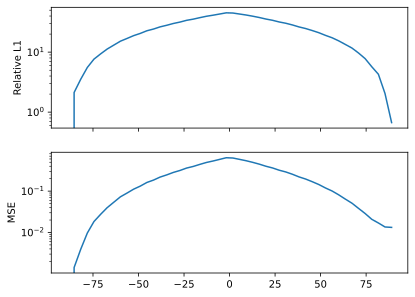

In [38]:
n_samples = 50
spp = 1

alphas = np.linspace(-89, 89, n_samples)
losses = {key: [] for key in LOSS_FNS.keys()}
for i, alpha in enumerate(alphas):
    scene, params = init_scene_params(alpha)
    
    image = mi.render(scene, params, seed=i, spp=spp)
    for key in LOSS_FNS.keys():
        losses[key].append(LOSS_FNS[key](image, img_ref))

fig, axs = plt.subplots(len(losses), 1, sharex=True)
for i, key in enumerate(losses.keys()):
    axs[i].semilogy(alphas, losses[key])
    axs[i].set_ylabel(key)
plt.show()

## Instantiate gradient descent optimization

In [73]:
opt = mi.ad.Adam(lr=0.02)

# Our latent variable
theta_init_value = 80.0
opt_key = "theta"
opt[opt_key] = mi.Float(theta_init_value)

_, param_zero = init_scene_params(0)
scene, params = init_scene_params(theta_init_value)

def update_scene(params, theta):
    params['PerspectiveCamera.to_world'] = mi.Transform4f.rotate(axis=[0,1,0], angle=theta) @ param_zero['PerspectiveCamera.to_world']
    params.update()

update_scene(params, opt[opt_key])
image_init = mi.render(scene, spp=1)
image_to_bm(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1, 1],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 3 B of image data ]
]

## Gradient descent

In [75]:
iteration_count = 100
for it in range(1, iteration_count+1):
    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params, spp=1)

    # Evaluate the objective function from the current rendered image
    loss = mse(image, img_ref)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()
    opt[opt_key] = dr.clamp(opt[opt_key], -89, 89)

    # Update the scene state to the new optimized values
    update_scene(params, opt[opt_key])

    print(f"Iteration {it:02d}: loss={to_float(loss):.3f}\ttheta={to_float(opt[opt_key]):.3f}", end='\r')
print('\nOptimization complete.')
image_to_bm(image)

Iteration 100: loss=0.019	theta=80.000
Optimization complete.


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1, 1],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 3 B of image data ]
]

## Global optimization

In [66]:
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

class ThetaOpt(Problem):
    def __init__(self, ref_img, loss_fn, spp):
        self.ref_img = ref_img
        self.loss_fn = loss_fn
        self.spp = spp
        super().__init__(n_var=1, n_obj=1, n_constr=0, xl=-89, xu=89)

    def _evaluate(self, x, out, *args, **kwargs):
        nb_samples = x.shape[0]
        out["F"] = np.array([0.0]*nb_samples)
        for i in range(nb_samples):
            scene, params = init_scene_params()
            update_scene(params, to_float(x[i]))
            image = mi.render(scene, params, seed=i, spp=self.spp)
            loss = to_float(self.loss_fn(image, self.ref_img))
            out["F"][i] = loss
    
    def show_res(self, x):
        scene, params = init_scene_params()
        update_scene(params, to_float(x))
        image = mi.render(scene, params, seed=0, spp=self.spp)
        return image_to_bm(image)

In [67]:
from pymoo.algorithms.soo.nonconvex.ga import GA

problem = ThetaOpt(img_ref, mse, 1)
algorithm = GA(pop_size=20, eliminate_duplicates=True)
res_ga = minimize(problem, algorithm, ('n_gen', 10), seed=0, verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       20 |  0.2536639514 |  0.0010484203
     2 |       40 |  0.0292012376 |  0.0010484203
     3 |       60 |  0.0102318554 |  0.0005934680
     4 |       80 |  0.0026672256 |  0.0000356714
     5 |      100 |  0.0004964871 |  5.357218E-06
     6 |      120 |  0.0001006933 |  9.977887E-07
     7 |      140 |  0.0000164075 |  2.571457E-11
     8 |      160 |  9.555999E-06 |  2.571457E-11
     9 |      180 |  2.845942E-06 |  2.571457E-11
    10 |      200 |  1.080690E-06 |  2.571457E-11


In [68]:
print(f"theta={to_float(res_ga.X)}")
problem.show_res(res_ga.X)

theta=-88.84980817490032


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1, 1],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 3 B of image data ]
]